In [1]:
%matplotlib inline

import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib as mpl
import matplotlib.pyplot as plt

# from svgd import svgd, update, phi_j_batched
from svgd import phi_j_batched
from utils import pairwise_distances, single_rbf

In [2]:
from jax.scipy.stats import norm

def p(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    out = 1/3 * norm.pdf(x, loc=-2, scale=1) + 2/3 * norm.pdf(x, loc=2, scale=1)
    return np.squeeze(out) # to be able to take a gradient, output must be scalar


def logp_old(x):
    return np.log(p(x))

In [8]:
def logp(x):
    """
    x must be a scalar
    """
    x = np.array(x)
    a = - (x + 2)**2 / 2 # mean -2
    b = - (x - 2)**2 / 2 # mean 2
    c = np.min([a, b])
    norm_co = 1 / np.sqrt(2 * np.pi)
    
    
    # normalize smallest element to 0, to avoid underflow errors
    expout = norm_co * (1/3 * np.exp(a - c) + 2/3 * np.exp(b - c))
    out = np.log(expout) + c
    return np.squeeze(out)

logp_batched = vmap(logp)

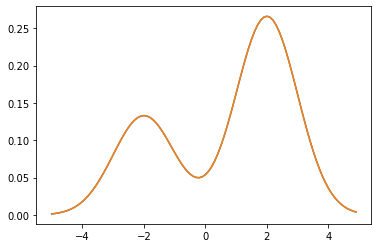

In [9]:
grid = np.arange(-5, 5, 0.1)
plt.plot(grid, p(grid))

plt.plot(grid, np.exp(logp_batched(grid)))

In [10]:
n = 30
stepsize = 0.01
L = int(1 / stepsize)
kernel_param_grid = np.logspace(-10, 15, num=25, base=2) # params smaller than 2^10 are generally awful
m = 10


q1 = lambda key, n: random.normal(key, shape=(n,1)) - 10
q2 = lambda key, n: random.normal(key, shape=(n,1)) * 3 + 10

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4665: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4665: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


### create NaN:

In [11]:
key = random.PRNGKey(6)
q = q2
x = q(key, n)
h = 0.0009765625

kernel_params = h

## note that logp(x) has -infs:
print(np.squeeze(x))
print(logp(x))
print()
print("x[6]: ", x[6])
print("logp(x[6]): ", logp(x[6]))

print("x[19]: ", x[19])
print(logp(x[19]))

[ 8.583897   5.1096616  8.13291   11.288309   9.527181  10.981857
 15.134769  10.941363  10.890869   3.682167  11.580569   7.028025
 14.022419   7.920472  12.096018  10.289377   7.223783  10.15488
  8.090013  16.500956   7.2901983 16.06377   10.049981  13.47894
 10.262466   3.7228546 10.611797   9.606102  10.00337    9.044173 ]
[       inf        inf        inf        inf        inf        inf
  -87.58549        inf        inf        inf        inf        inf
        inf        inf        inf        inf        inf        inf
        inf -106.46326        inf -100.21922        inf        inf
        inf        inf        inf        inf        inf        inf]

x[6]:  [15.134769]
logp(x[6]):  -87.58549
x[19]:  [16.500956]
-106.46326


In [12]:
kernel = lambda x, y: single_rbf(x, y, kernel_params)

xi = x[6]
repeated = np.tile(xi, (n, 1))
np.squeeze(phi_j_batched(x, repeated, logp, kernel))

DeviceArray([  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
               0.      , -13.134769,   0.      ,   0.      ,   0.      ,
               0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
               0.      ,   0.      ,   0.      ,   0.      ,  -0.      ,
               0.      ,  -0.      ,   0.      ,   0.      ,   0.      ,
               0.      ,   0.      ,   0.      ,   0.      ,   0.      ],            dtype=float32)

NaN here:

In [13]:
kernel = lambda x, y: single_rbf(x, y, kernel_params)

xnew = []
n = x.shape[0]
for i, xi in enumerate(x):
    repeated = np.tile(xi, (n, 1))
    xnew.append(stepsize * np.sum(phi_j_batched(x, repeated, logp, kernel), axis = 0))
xnew = np.array(xnew)
xnew += x
np.squeeze(xnew)

DeviceArray([ 8.518058 ,  5.078565 ,  8.219062 , 11.195426 ,  9.415469 ,
             11.04467  , 15.003422 , 10.750119 , 10.622835 ,  3.4794586,
             11.484763 ,  6.977745 , 13.902195 ,  7.8612666, 11.995058 ,
             10.339773 ,  7.0949364, 10.073596 ,  7.8339896, 16.355946 ,
              7.3029165, 15.923133 , 10.095963 , 13.364151 ,  9.935158 ,
              3.8769245, 10.52568  ,  9.560245 ,  9.73993  ,  8.973732 ],            dtype=float32)

### but sometimes there are `-inf`s without a `NaN`.

In [ ]:
key = random.PRNGKey(1)
x = q2(key, n)
# print(np.squeeze(x))
print("logp(x[15]): ", logp(x[15]))
print(x[15])
print(np.sort(x[:, 0]))
print(logp(np.sort(x[:, 0])))

In [ ]:
kernel = lambda x, y: single_rbf(x, y, kernel_params)

xi = x[6]
repeated = np.tile(xi, (n, 1))
np.squeeze(phi_j_batched(x, repeated, logp, kernel))